Dataset foi, provavelmente, gerado sem restraints necessarios. Valores como mediana do rating para cada classe de linha de produto tem proximidade de 2 casas decimais entre quase todas elas. Entre outros valores que são exatamente os mesmos entre várias colunas considerando agrupamentos por linha_de_produto



In [239]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import random
import math
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.losses import MeanSquaredLogarithmicError
from sklearn.metrics import mean_squared_log_error

In [3]:
data = pd.read_csv('/content/supermarket_sales - Sheet1.csv')

In [4]:
data.head()

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,13:08,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,13:23,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,1/27/2019,20:33,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2/8/2019,10:37,Ewallet,604.17,4.761905,30.2085,5.3


In [5]:
data.isna().sum() #checando a presencao de valores nulos

Invoice ID                 0
Branch                     0
City                       0
Customer type              0
Gender                     0
Product line               0
Unit price                 0
Quantity                   0
Tax 5%                     0
Total                      0
Date                       0
Time                       0
Payment                    0
cogs                       0
gross margin percentage    0
gross income               0
Rating                     0
dtype: int64

##Exclua as colunas: "cogs", "gross margin percentage", "gross income". provavelmente pois a relação entre os valores dessas colunas (principalmente em relacao aos valores da coluna tax 5% não fazem muito sentido)?

In [6]:
try:

  data = data.drop(['cogs', 'gross margin percentage', 'gross income'], axis = 1)
except Exception as e:

  #checar se as 3 colunas a serem dropadas estao presentes no dataframe em que a ação foi tentada

  if all(coluna in data.columns for coluna in ['cogs', 'gross margin percentage', 'gross income']):

    print(e) #caso estejam presentes, significa que o erro nao foi causado pela ausencia dessas colunas no dataframe, printar a exceção

  else: #caso as 3 colunas estejam presentes no dataframe em que a acao foi tentada

    print("Pelo menos uma das três colunas não estão presentes no dataframe.") #caso nao estejam presentes, o erro foi causado por essa ausencia


In [7]:
data.head()

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,Rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,13:08,Ewallet,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29,Cash,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,13:23,Credit card,7.4
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,1/27/2019,20:33,Ewallet,8.4
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2/8/2019,10:37,Ewallet,5.3


##Utilize Regex para identificar IDs com terminações entre '47' e '57' e substitua esses dois últimos valores por '00'.

In [8]:
def substituir_ids(invoice_id):

  #utilizar expressao regex para buscar valores de acordo com a especificacao 3numeros contrabarra 2numeros 1 barra 2numeros(sendo eles 47 ou 57) finalizando

  padrao = r'\d{3}-\d{2}-\d{2}(47|57)$'


  if re.match(padrao, invoice_id) :

    invoice_id = invoice_id[:-2] + '00'

    print(invoice_id)

  return invoice_id

In [9]:
data['Invoice ID'] = data['Invoice ID'].apply(substituir_ids) #utilizat apply para aplicar a funcao substituir_ids; substituindo os valores da coluna invoice id que sigam o padrao do regex especificado

510-95-6300
787-56-0700
336-78-2100
189-08-9100
700-81-1700
414-12-7000
434-83-9500
721-86-6200
787-15-1700
730-61-8700
346-12-3200
470-32-9000
534-01-4400
857-67-9000
760-90-2300
740-11-5200
190-14-3100
266-20-6600
243-55-8400
518-71-6800


In [10]:
padrao = r'\d{3}-\d{2}-\d{2}(47|57)$'

In [11]:
atende_padrao = data['Invoice ID'].str.extract(padrao).any().any()

print(atende_padrao) # caso verdadeiro, alguns termos com final 47 ou 57 nao foram retirados com sucesso, caso falso, todos esses foram retirados com sucesso

False


##Qual é a média mensal de vendas?

In [12]:
data.head()

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,Rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,13:08,Ewallet,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29,Cash,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,13:23,Credit card,7.4
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,1/27/2019,20:33,Ewallet,8.4
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2/8/2019,10:37,Ewallet,5.3


In [13]:
data['Date'] = pd.to_datetime(data['Date'])


In [14]:
dataframe_agrupado_por_mes = data.groupby(data['Date'].dt.month)

In [15]:
media_por_mes = dataframe_agrupado_por_mes['Total'].mean()

In [16]:
media_por_mes

Date
1    330.374625
2    320.856020
3    317.262339
Name: Total, dtype: float64

##Qual é a linha de produtos mais bem avaliada? Gere um gráfico de Pizza.


In [17]:
data_ordenada_decrescente = data.sort_values(by='Rating', ascending=False) #ordenar para facilitar a próxima atividade

In [18]:
dataframe_agrupado_por_linha_produto = data_ordenada_decrescente.groupby(data_ordenada_decrescente['Product line']) #agrupar para aplicar media, mediana desvio padrao

In [19]:
avaliacao_media_por_linha_produto = dataframe_agrupado_por_linha_produto['Rating'].mean()      #pegar media de avaliacao para cada linha de produto

In [20]:
avaliacao_media_por_linha_produto

Product line
Electronic accessories    6.924706
Fashion accessories       7.029213
Food and beverages        7.113218
Health and beauty         7.003289
Home and lifestyle        6.837500
Sports and travel         6.916265
Name: Rating, dtype: float64

In [21]:
desvio_padrao__por_linha_produto = dataframe_agrupado_por_linha_produto['Rating'].std()  #pegar desvio padrao de avaliacao para cada linha de produto

In [22]:
desvio_padrao__por_linha_produto #desvios padroes proximos

Product line
Electronic accessories    1.702028
Fashion accessories       1.713437
Food and beverages        1.715181
Health and beauty         1.763817
Home and lifestyle        1.718627
Sports and travel         1.714477
Name: Rating, dtype: float64

In [23]:
avaliacao_mediana_por_linha_produto = dataframe_agrupado_por_linha_produto['Rating'].median() #pegar mediana de avaliacao para cada linha de produto

In [24]:
avaliacao_mediana_por_linha_produto.values #food and beverages possui tanto a maior média quanto maior mediana das avaliações

array([6.7 , 6.95, 7.3 , 7.2 , 7.  , 6.7 ])

In [25]:
quartis_por_linha_produto = dataframe_agrupado_por_linha_produto['Rating'].quantile([0.25, 0.5, 0.75]) #pegando os quartis de avaliacao para cada linha de produto

In [26]:
quartis_por_linha_produto.head

<bound method NDFrame.head of Product line                
Electronic accessories  0.25    5.500
                        0.50    6.700
                        0.75    8.350
Fashion accessories     0.25    5.600
                        0.50    6.950
                        0.75    8.500
Food and beverages      0.25    5.800
                        0.50    7.300
                        0.75    8.600
Health and beauty       0.25    5.450
                        0.50    7.200
                        0.75    8.400
Home and lifestyle      0.25    5.400
                        0.50    7.000
                        0.75    8.200
Sports and travel       0.25    5.525
                        0.50    6.700
                        0.75    8.450
Name: Rating, dtype: float64>

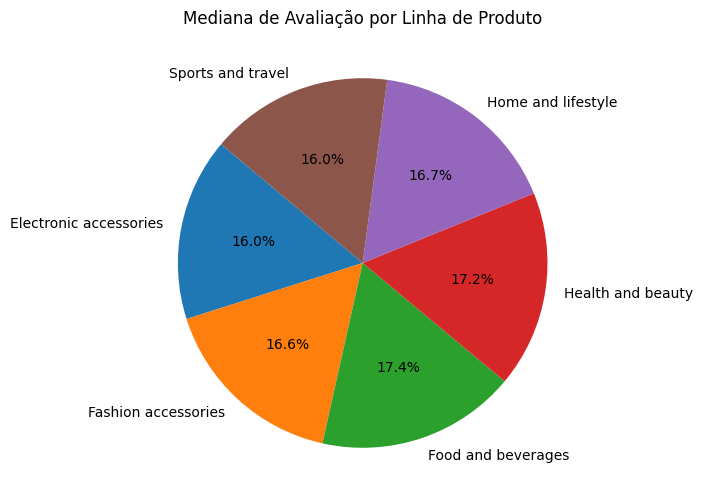

In [27]:
labels_da_avaliacao_mediana_por_linha_produto = avaliacao_mediana_por_linha_produto.index #plotando gráfico pizza das medianas de cada avaliação por linha de produto


plt.figure(figsize=(6, 6))

#definindo as medianas de avaliacoes e mantendo seu label de acordo com o index de cada linha de produto

plt.pie(avaliacao_mediana_por_linha_produto, labels = labels_da_avaliacao_mediana_por_linha_produto, autopct='%1.1f%%', startangle=140)


plt.title("Mediana de Avaliação por Linha de Produto")


plt.show()

In [28]:
# Considerando que Food and beverages possui tanto a maior média quanto maior mediana de rating entre todas as linhas de produto, então é a mais bem avaliada.

##Quais são os 5 produtos mais caros de acordo com a linha de produtos?

In [29]:
 #acessando o dataframe criado a partir da agrupacao dos produtos pelo valor da coluna linha de produto e, entao,
 #pegando os 5 produtos que possuem valor mais alto para a coluna unit price(os mais caros) e ordenando-os de acordo com sua linha
dataframe_agrupado_por_linha_produto.head(5).sort_values(by = 'Product line')[['Product line', 'Unit price']]

,Product line,Unit price
370,Electronic accessories,26.26
853,Electronic accessories,52.79
505,Electronic accessories,24.18
23,Electronic accessories,34.56
194,Electronic accessories,32.71
766,Fashion accessories,76.06
762,Fashion accessories,63.88
86,Fashion accessories,76.52
960,Fashion accessories,91.98
67,Fashion accessories,97.61


In [30]:
#nao fui capaz de encontrar, na documentacao do dataset, se os valores para unit price são sempre unicos- mesmo para uma mesma linha de produto.
#Posso ter produtos diferentes com mesmo preco unitario?

In [31]:
#realizar o abaixo caso valores repetidos de unit price para uma mesma linha de produto signifiquem produtos diferentes

In [32]:
#excluindo registros que possuam o mesmo valor tanto de unit price e product line, evitando considerar mais de 1 vez o mesmo produto
data_ordenada_decrescente_casos_unicos = data_ordenada_decrescente.drop_duplicates(subset=['Product line', 'Unit price'])

In [33]:
#checar quantos registros foram excluidos
print(f'len(data_ordenada_decrescente): {len(data_ordenada_decrescente)}\nlen(data_ordenada_decrescente_casos_unicos): {len(data_ordenada_decrescente_casos_unicos)}')

len(data_ordenada_decrescente): 1000
len(data_ordenada_decrescente_casos_unicos): 993


In [34]:
data_casos_unicos_agrupado_por_linha_produto = data_ordenada_decrescente_casos_unicos.groupby(data_ordenada_decrescente['Product line']) #agrupando os registros por linha de produto

In [35]:
data_casos_unicos_agrupado_por_linha_produto.head(5).sort_values(by = 'Product line')[['Product line', 'Unit price']]

,Product line,Unit price
370,Electronic accessories,26.26
853,Electronic accessories,52.79
505,Electronic accessories,24.18
23,Electronic accessories,34.56
194,Electronic accessories,32.71
766,Fashion accessories,76.06
762,Fashion accessories,63.88
86,Fashion accessories,76.52
960,Fashion accessories,91.98
67,Fashion accessories,97.61


##Quais são os 10 produtos mais populares (vendidos com maior frequência)? E os 10 menos populares?


In [36]:
#ordenar para facilitar a definicao dos produtos para cada categoria- mais vendidos ou menos vendidos, de acordo com o valor da coluna Quantity de cada registro
data_ordenada_decrescente_quantidade = data.sort_values(by='Quantity', ascending=False)[['Unit price', 'Product line', 'Quantity']]  #mantendo apenas as 3 colunas requeridas

In [37]:
#agrupando os registros de acordo com combinacoes dos valores das colunas Unit price e Product line
#Modificando o valor da coluna quantity de cada grupo para a soma dos valores presentes nas colunas quantity de cada registro desse grupo
data_agrupada_linha = data.groupby(['Unit price', 'Product line']).agg({'Quantity': 'sum'})

In [38]:
#retornando os 10 produtos com maior quantidade vendida
produtos_mais_vendidos = data_agrupada_linha.nlargest(10, 'Quantity')

In [39]:
produtos_mais_vendidos

,,Quantity
Unit price,Product line,
34.42,Home and lifestyle,12
99.82,Fashion accessories,11
10.96,Food and beverages,10
12.12,Home and lifestyle,10
13.50,Health and beauty,10
14.36,Sports and travel,10
15.50,Sports and travel,10
15.80,Home and lifestyle,10
15.81,Sports and travel,10


In [40]:
#retornando os 10 produtos com menos quantidade vendida
produtos_menos_vendidos= data_agrupada_linha.nsmallest(10, 'Quantity')

In [41]:
produtos_menos_vendidos

,,Quantity
Unit price,Product line,
10.17,Sports and travel,1
12.09,Fashion accessories,1
12.54,Fashion accessories,1
12.78,Fashion accessories,1
13.98,Home and lifestyle,1
15.34,Sports and travel,1
15.43,Fashion accessories,1
15.50,Fashion accessories,1
16.28,Fashion accessories,1


In [42]:
#realizar o abaixo caso valores repetidos de unit price para uma mesma linha de produto signifiquem produtos diferentes

In [43]:
#agrupando os registros, a partir do dataframe original, de acordo com repeticao tanto do valor da coluna product line quanto da coluna unit price.
#Ou seja, agrupando aqueles registros que possuem valores identicos para ambas as colunas ao mesmo tempo.
#Entao pegando a soma da coluna quantity de cada um dos registrosa agrupados e definindo o valor dessa soma para o registro proveniente desse agrupamento
data_casos_unicos_agrupado_por_linha_e_preco = data.groupby(['Product line', 'Unit price'])['Quantity'].sum().reset_index()

In [44]:
produtos_mais_vendidos = data_casos_unicos_agrupado_por_linha_e_preco.nlargest(10, 'Quantity')

In [45]:
produtos_mais_vendidos

,Product line,Unit price,Quantity
710,Home and lifestyle,34.42,12
342,Fashion accessories,99.82,11
12,Electronic accessories,17.42,10
20,Electronic accessories,21.43,10
25,Electronic accessories,22.95,10
30,Electronic accessories,24.74,10
36,Electronic accessories,26.26,10
51,Electronic accessories,32.80,10
62,Electronic accessories,40.26,10
63,Electronic accessories,40.30,10


In [46]:
produtos_menos_vendidos= data_casos_unicos_agrupado_por_linha_e_preco.nsmallest(10, 'Quantity')

In [47]:
produtos_menos_vendidos

,Product line,Unit price,Quantity
32,Electronic accessories,25.45,1
45,Electronic accessories,28.96,1
47,Electronic accessories,30.24,1
59,Electronic accessories,38.60,1
60,Electronic accessories,39.48,1
61,Electronic accessories,39.75,1
73,Electronic accessories,46.20,1
95,Electronic accessories,60.30,1
97,Electronic accessories,60.95,1
99,Electronic accessories,62.48,1


##Existe alguma correlação entre o preço de um produto e a quantidade vendida?

In [48]:
#definindo uma funcao para aplicar o label encoder sobre todas as colunas do dataframe original, transformando variaveis categorias em numericas
def label_encode(data, coluna):

  #checando se os dados presentes na coluna sao do tipo objeto; se sim, então se trata de uma variável categorica e o processo de encode será aplicado

  if data[coluna].dtype == 'O':

    label_encoder = LabelEncoder()

    data[coluna] = label_encoder.fit_transform(data[coluna])


In [49]:
#copiando o dataframe original para realizar o encode sobre a copia. Evitando modificar o dataframe original
data_copia = data.copy()

In [50]:
for coluna in data.columns:

  label_encode(data_copia, coluna)


In [51]:
data_copia.head()

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,Rating
0,814,0,2,0,0,3,74.69,7,26.1415,548.9715,2019-01-05,146,2,9.1
1,142,2,1,1,0,0,15.28,5,3.8200,80.2200,2019-03-08,23,0,9.6
2,653,0,2,1,1,4,46.33,7,16.2155,340.5255,2019-03-03,155,1,7.4
3,18,0,2,0,1,3,58.22,8,23.2880,489.0480,2019-01-27,485,2,8.4
4,339,0,2,1,1,5,86.31,7,30.2085,634.3785,2019-02-08,29,2,5.3


In [52]:
#checando correlacao entre as variaveis quantidade e preco unitario
correlacao_preco_quantidade = data_copia['Quantity'].corr(data_copia['Unit price'])

In [53]:
correlacao_preco_quantidade

0.010777564342497272

In [54]:
#checando as correlacoes entre cada par de variaveis
correlacoes_gerais = data_copia.corr()

<ipython-input-54-c7fe00fe6178>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlacoes_gerais = data_copia.corr()


In [55]:
correlacoes_gerais

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Time,Payment,Rating
Invoice ID,1.000000,-0.041753,0.031247,0.070519,0.023552,0.027589,-0.009213,0.024977,0.027277,0.027277,0.009224,0.021478,-0.003787
Branch,-0.041753,1.000000,-0.507401,-0.019608,-0.056318,-0.053938,0.028202,0.015964,0.041047,0.041047,0.035921,-0.050104,0.010238
City,0.031247,-0.507401,1.000000,0.004899,0.012219,0.008811,-0.013763,-0.002121,-0.012812,-0.012812,-0.066115,0.019094,0.049585
Customer type,0.070519,-0.019608,0.004899,1.000000,0.039996,-0.036800,-0.020238,-0.016763,-0.019670,-0.019670,-0.020162,0.018073,0.018889
Gender,0.023552,-0.056318,0.012219,0.039996,1.000000,0.005193,0.015445,-0.074258,-0.049451,-0.049451,0.085054,0.044578,0.004800
Product line,0.027589,-0.053938,0.008811,-0.036800,0.005193,1.000000,0.019321,0.020256,0.031621,0.031621,-0.058607,0.029896,-0.020529
Unit price,-0.009213,0.028202,-0.013763,-0.020238,0.015445,0.019321,1.000000,0.010778,0.633962,0.633962,0.008155,-0.015941,-0.008778
Quantity,0.024977,0.015964,-0.002121,-0.016763,-0.074258,0.020256,0.010778,1.000000,0.705510,0.705510,-0.009045,-0.003921,-0.015815
Tax 5%,0.027277,0.041047,-0.012812,-0.019670,-0.049451,0.031621,0.633962,0.705510,1.000000,1.000000,-0.005298,-0.012434,-0.036442
Total,0.027277,0.041047,-0.012812,-0.019670,-0.049451,0.031621,0.633962,0.705510,1.000000,1.000000,-0.005298,-0.012434,-0.036442


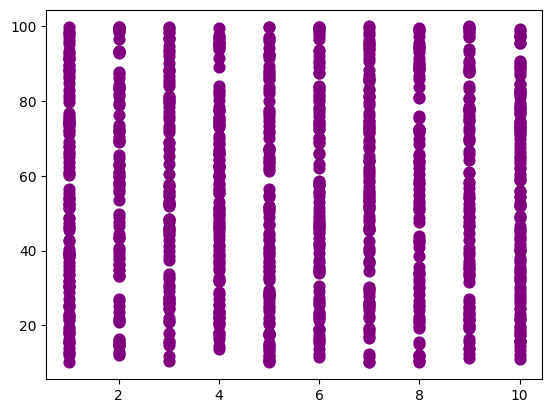

In [56]:
#plotando grafico de dispersao para cada registro, levando em conta y = preco unitario no registro e x = unidades no registro
plt.scatter(data_copia['Quantity'], data_copia['Unit price'], s=60, c='purple')

In [57]:
#Considerando as correlacoes presentes entre as variaveis(colunas) do dataframe e o plot de dispersao acima, a já ínfima correlacao entre quantidade e preco unitario demonstra ser muito fraca ou até mesmo insignificante

##Existe alguma correlação entre o preço de um produto e o método de pagamento? Gere um gráfico de Dispersão.

In [58]:
correlacao_preco_metodo_de_pagamento = data_copia['Payment'].corr(data_copia['Unit price'])

In [59]:
correlacao_preco_metodo_de_pagamento

-0.015941047861448975

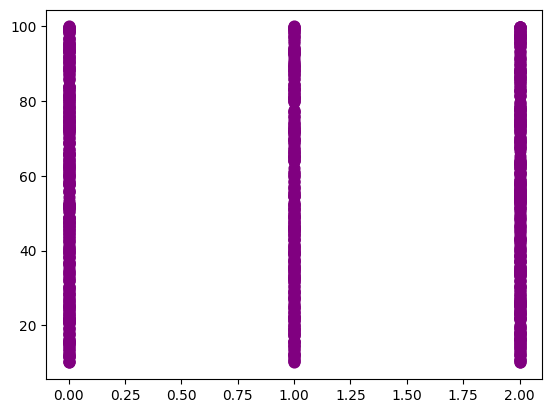

In [60]:
plt.scatter(data_copia['Payment'], data_copia['Unit price'], s=60, c='purple')

In [61]:
#Considerando as correlacoes presentes entre as variaveis(colunas) do dataframe e o plot de dispersao acima, a já ínfima correlacao entre  preço de um produto e o método de pagamento demonstra ser muito fraca ou até mesmo insignificante

Mesmo considerando a variação ao levar em contar que cada combinacao unica de preco unitario e linha de produto signifique sempre um mesmo produto, as variacoes nessa modificacao de entendimento possuem impacto irrelevante na correlacao. Isso considerando que apenas 7 de 1000 registros foram apagados ao retirar duplicatas.

In [62]:
#checar quantos registros foram excluidos
print(f'len(data_ordenada_decrescente): {len(data_ordenada_decrescente)}\nlen(data_ordenada_decrescente_casos_unicos): {len(data_ordenada_decrescente_casos_unicos)}')

len(data_ordenada_decrescente): 1000
len(data_ordenada_decrescente_casos_unicos): 993


##Qual é o perfil de cliente que mais compra? Leve em conta cidade, tipo de cliente e gênero.

In [63]:
data.head()

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,Rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,2019-01-05,13:08,Ewallet,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,2019-03-08,10:29,Cash,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,2019-03-03,13:23,Credit card,7.4
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,2019-01-27,20:33,Ewallet,8.4
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2019-02-08,10:37,Ewallet,5.3


In [64]:
#ordenando os registros de forma decrescente de acordo com o valor da coluna Quantity
data_ordenada_quantity = data.sort_values(by = 'Quantity', ascending = False)

In [65]:
#agrupando o dataframe ordenado anteriormente de acordo com combinacoes das colunas City, Customer Type e Gender.
#Modificando o valor da coluna quantity de cada grupo para a soma dos valores presentes nas colunas quantity de cada registro desse grupo
data_group_by_cidade_tipo_genero = data.groupby(['City', 'Customer type', 'Gender']).agg({'Quantity': 'sum'})

In [66]:
#pegando id do registro do group by com vaior valor pra a coluna quantity; registro esse correspondente ao perfil de usuario que mais comprou
grupo_com_maior_soma = data_group_by_cidade_tipo_genero['Quantity'].idxmax()

In [67]:
data_group_by_cidade_tipo_genero.loc[grupo_com_maior_soma]

Quantity    548
Name: (Naypyitaw, Member, Female), dtype: int64

##Quais são os meses de pico de vendas? E os meses mais fracos? Gere um gráfico de sua escolha para exemplificar essas diferenças.


In [68]:
data.head()

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,Rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,2019-01-05,13:08,Ewallet,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,2019-03-08,10:29,Cash,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,2019-03-03,13:23,Credit card,7.4
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,2019-01-27,20:33,Ewallet,8.4
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2019-02-08,10:37,Ewallet,5.3


In [69]:
#copiando o dataframe para n realizar modificacoes no original
data_indexado_mes = data.copy()

In [70]:
#garantindo que a coluna Date possui valores do tipo datetime
data_indexado_mes['Date'] = pd.to_datetime(data_indexado_mes['Date'])


In [71]:
#definindo uma nova coluna no dataframe indexado contendo mes/ano de cada registro
data_indexado_mes['MesAno'] = data['Date'].dt.to_period('M')

In [72]:
#agrupando os registros de acordo com a coluna MonthYear; possuidora dos valores de mes e ano.
#Em cada agrupamento, o valor da coluna quantidade é definida pela soma dos valores da coluna quantidade para cada um dos registros em determinado agrupamento. Reset index reseta o indice para o padr]ao (0, 1, 2, etc)
data_agrupado_mes_ano = data_indexado_mes.groupby('MesAno')['Quantity'].sum().reset_index()

In [73]:
#ordenando os valores desse agrupamento de forma decrescente de acordo com o valor da coluna quantity
data_agrupado_mes_ano_decrescente_quantidade = data_agrupado_mes_ano.sort_values(by='Quantity', ascending=False)

In [74]:
#retornando os agrupamentos mes/ano em ordem decrescente de acordo com o valor para a coluna quantity
meses_anos_mais_vendas = data_agrupado_mes_ano_decrescente_quantidade.head()

In [75]:
meses_anos_mais_vendas

,MesAno,Quantity
0,2019-01,1965
2,2019-03,1891
1,2019-02,1654


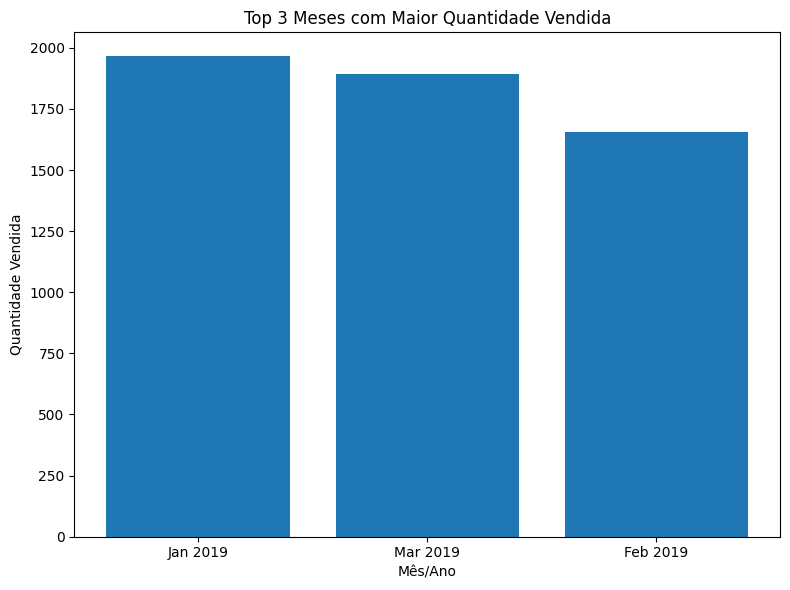

In [76]:
#plottando um grafico de barras com a cordenada dependente sendo os valores de venda de cada agrupamento mes/ano e a variavel independente sendo a combinacao mes/ano

plt.figure(figsize=(8, 6))

plt.bar(meses_anos_mais_vendas['MesAno'].dt.strftime('%b %Y'), meses_anos_mais_vendas['Quantity'])

plt.xlabel('Mês/Ano')

plt.ylabel('Quantidade Vendida')

plt.title('Top 3 Meses com Maior Quantidade Vendida')


plt.tight_layout()

plt.show()

##Qual filial gera mais receita?

In [77]:
data.head(5)

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,Rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,2019-01-05,13:08,Ewallet,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,2019-03-08,10:29,Cash,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,2019-03-03,13:23,Credit card,7.4
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,2019-01-27,20:33,Ewallet,8.4
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2019-02-08,10:37,Ewallet,5.3


In [78]:
#dividir o valor total de receita pela quantidade de meses entre a ultima venda e a primeira

In [79]:
548.97125 * 0.05

27.448562500000005

In [80]:
#copiando o dataframe para n realizar modificacoes no original
data_com_coluna_lucro = data.copy()

In [81]:
#gerando a coluna lucro de acordo com a diferenca entre os valores da coluna total e da coluna tax 5%
data_com_coluna_lucro['Lucro'] = data['Total'] - data['Tax 5%']

In [82]:
#certificando de que o tipo dos valores presentes na coluna date é datetime
data_com_coluna_lucro['Date'] = pd.to_datetime(data_com_coluna_lucro['Date'])

In [83]:
#agrupando o dataframe acima de acordo com o valor da coluna Branch
data_com_coluna_lucro_agrupado_filial = data_com_coluna_lucro.groupby('Branch')

In [84]:
#transformando os valores da coluna lucro de cada agrupamento para soma dos valores de cada registro em determinado agrupamento.
#transformando os valores da coluna Date de cada agrupamento para a diferenca entre os valores maximo e minimos da coluna date para determinado agrupamento
data_com_coluna_lucro_agrupado_filial = data_com_coluna_lucro_agrupado_filial.agg({'Lucro': 'sum', 'Date': ['min', 'max']})

In [85]:
#remover um nivel de cada coluna para facilitar acesso das mesmas
data_com_coluna_lucro_agrupado_filial.columns = data_com_coluna_lucro_agrupado_filial.columns.droplevel()

In [87]:
#gerando uma coluna Season para armazenar a diferenca entre os valores maximos e minimos de date para definir o tempo entre a primeira e ultima venda de cada agrupamento de branch
data_com_coluna_lucro_agrupado_filial['Tempo em atividade'] = (data_com_coluna_lucro_agrupado_filial['max'] - data_com_coluna_lucro_agrupado_filial['min']).dt.days

In [88]:
#reseta o indice do dataframe para o padrao de (0, 1, 2, etc)
data_com_coluna_lucro_agrupado_filial = data_com_coluna_lucro_agrupado_filial.reset_index()

In [89]:
#gera a coluna lucro por tempo para armazenar o quanto de receita foi gerada por cada loja divido pela quantidade de dias entre o date maximo e minino de cada agrupamento de branch
data_com_coluna_lucro_agrupado_filial['Lucro por Tempo'] = data_com_coluna_lucro_agrupado_filial['sum'] / data_com_coluna_lucro_agrupado_filial['Tempo em atividade']

In [90]:
#ordenando os valores do dataframe anterior de acordo com o valor da coluna lucro por tempo de cada agrupamento
data_com_coluna_lucro_agrupado_filial.sort_values(by='Lucro por Tempo', ascending=False)

,Branch,sum,min,max,Tempo em atividade,Lucro por Tempo
2,C,105303.53,2019-01-01,2019-03-30,88,1196.631023
0,A,101143.21,2019-01-01,2019-03-30,88,1149.354659
1,B,101140.64,2019-01-01,2019-03-30,88,1149.325455


##Há uma diferença no padrão de vendas durante os dias da semana e os fins de semana?

In [92]:
data_teste_kolmogorov = data.copy()

In [105]:
#gerando uma coluna DiaDaSemana para armazenar as datas de cada registro mas de acordo com seu valor de dia da semana (0, 1, 2, etc)
data_teste_kolmogorov['DiaDaSemana'] = data_teste_kolmogorov['Date'].dt.dayofweek

In [106]:
#guardando as vendas dos dias da semana ("dias uteis") na variavel vendas_semana
vendas_semana = data_teste_kolmogorov[data_teste_kolmogorov['DiaDaSemana'].isin([0, 1, 2, 3, 4])]['Quantity']

In [107]:
#guardando as vendas dos dias de final de semana na variavel vendas_fim_de_semana
vendas_fim_de_semana = data_teste_kolmogorov[data_teste_kolmogorov['DiaDaSemana'].isin([5, 6])]['Quantity']

In [108]:
#realizar o teste Kolmogorov-Smirnov (ks_2samp) para determinar o valor p de acordo com a significancia do teste. Quanto menor o valor, maior a significancia e maior a diferenca entre as dsitribuicoes.
ks_stat, ks_valor_p = stats.ks_2samp(vendas_semana, vendas_fim_de_semana)

In [109]:
#definindo o valor p alfa. A partir dele, a hipótese nula será rejeitada ou aceita.
#Hipótese nula sendo de que não há diferença entre as distribuicoes de vendas dias da semana e vendas final de semana
alfa = 0.05

In [110]:
#checando se o valor p do teste Kolmogorov-Smirnov é maior ou menor que valor alfa. Se for maior, significa que a hipótese nula nao foi rejeitada. Se for menor, a hipótese nula é rejeitada e a alternativa é adotada
if ks_valor_p < alfa:
    print("H0 rejeitada: As distribuições são diferentes, indicando um padrão de vendas diferente.")
else:
    print("H0 não rejeitada: Não há evidências suficientes para afirmar diferenças nas distribuições.")

print(f'ks_valor_p: {ks_valor_p}')

H0 não rejeitada: Não há evidências suficientes para afirmar diferenças nas distribuições.
ks_valor_p: 0.3936187424694938


##Desenvolva uma rede neural para prever as vendas de um produto com base em suas características. Utilize uma divisão adequada entre conjunto de treinamento e teste, e avalie o desempenho do modelo.

In [242]:
data.head()

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,Rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,2019-01-05,13:08,Ewallet,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,2019-03-08,10:29,Cash,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,2019-03-03,13:23,Credit card,7.4
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,2019-01-27,20:33,Ewallet,8.4
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2019-02-08,10:37,Ewallet,5.3


In [243]:
#definindo o dataframe a ser utilizado para o desafio, contendo apenas as 3 colunas necessarios para o treinamento e avaliacao do modelo.
#As duas primeiras sendo caracteristicas independentes e a ultima sendo a caracteristica dependente
data_desafio = data[['Product line', 'Unit price', 'Quantity']]

In [244]:
data_desafio.head()

,Product line,Unit price,Quantity
0,Health and beauty,74.69,7
1,Electronic accessories,15.28,5
2,Home and lifestyle,46.33,7
3,Health and beauty,58.22,8
4,Sports and travel,86.31,7


In [245]:
#aplicando one hot encode na coluna product line para transformar seus labels em valores binarios; para posteriormente substituir essa coluna original
one_hot = pd.get_dummies(data_desafio['Product line'])

In [246]:
#dropando a coluna product line
data_desafio = data_desafio.drop('Product line', axis = 1)

In [247]:
#juntando os valores one hot encodeds da coluna original product line ao restante do dataframe data_desafio
data_desafio = data_desafio.join(one_hot)

In [248]:
#embaralhando os registros, para diminuir a possibilidade de vieses
data_desafio = data_desafio.sample(frac=1, random_state=42).reset_index(drop=True)

In [249]:
data_desafio.head()

,Unit price,Quantity,Electronic accessories,Fashion accessories,Food and beverages,Health and beauty,Home and lifestyle,Sports and travel
0,83.17,6,0,0,0,0,1,0
1,58.76,10,1,0,0,0,0,0
2,55.61,7,0,0,0,0,1,0
3,42.97,3,0,0,0,0,0,1
4,21.87,2,0,0,0,0,0,1


In [250]:
#definindo as colunas independentes
x = data_desafio.drop('Quantity', axis = 1)

In [251]:
#definindo a coluna dependente
y = data_desafio['Quantity']

In [252]:
print(f'len x: {len(x)}, len y: {len(y)}')

len x: 1000, len y: 1000


In [253]:
#separando os dados entre aqueles de treino e aqueles de teste (separados tbm de acordo com variaveis dependentes e independentes)
x_train, x_test, y_train, y_test = train_test_split(x, y)

In [254]:
print(f'len x_train: {len(x_train)}, len x_test: {len(x_test)}, len y_train: {len(y_train)}, len y_test: {len(y_test)}')

len x_train: 750, len x_test: 250, len y_train: 750, len y_test: 250


In [255]:
standard_scaler_treino = StandardScaler()


In [256]:
standard_scaler_teste = StandardScaler()

In [257]:
#dois objetos StandardScaler foram instanciados com intuito de evitar possiveis vazamentos de informacao caso aplique a mesma instancia tanto para treino quanto para teste

In [258]:
#escalonando os valores da coluna Unit price de x_train
x_train['Unit price'] = standard_scaler_treino = StandardScaler().fit_transform(x_train['Unit price'].values.reshape(-1, 1))

In [259]:
#escalonando os valores da coluna Unit price de x_test
x_test['Unit price'] = standard_scaler_teste.fit_transform(x_test['Unit price'].values.reshape(-1, 1))

In [260]:
x_train.head()

,Unit price,Electronic accessories,Fashion accessories,Food and beverages,Health and beauty,Home and lifestyle,Sports and travel
834,1.174490,0,0,0,0,0,1
883,-0.335248,0,0,0,0,1,0
716,0.325641,0,0,0,0,1,0
854,0.984636,0,0,0,1,0,0
149,-0.602407,0,0,0,1,0,0


In [261]:
x_test.head()

,Unit price,Electronic accessories,Fashion accessories,Food and beverages,Health and beauty,Home and lifestyle,Sports and travel
801,-0.400996,1,0,0,0,0,0
908,-1.383070,0,1,0,0,0,0
733,1.448670,0,0,0,0,1,0
240,0.055435,0,0,0,1,0,0
229,0.644305,0,1,0,0,0,0


In [262]:
#estrurando as camadas do modelo de rede neural; seus shapes, kernel e funcao de ativacao

hidden_units1 = 160

hidden_units2 = 480

hidden_units3 = 256

learning_rate = 0.01

def build_model_using_sequential():
  model = Sequential([
    Dense(hidden_units1, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(hidden_units2, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(hidden_units3, kernel_initializer='normal', activation='relu'),
    Dense(1, kernel_initializer='normal', activation='linear')
  ])
  return model

model = build_model_using_sequential()

In [263]:
#definindo a loss function a ser utilizada. Ela serve como parametro para o treinamento do modelo, o quao vai buscar minimiza-la
msle = MeanSquaredLogarithmicError()

#compilando o modelo com sua loss function, otimizador(que recebe como parametro a taxa de aprendizado)
model.compile(
    loss=msle,
    optimizer=Adam(learning_rate=learning_rate),
    metrics=[msle]
)

#dando fit no modelo com os dados para treinamento, no caso, x_train.values e y_train.values
history = model.fit(
    x_train.values,
    y_train.values,
    epochs=150,
    batch_size=64,
    validation_split=0.2
)

Epoch 1/150
10/10 [==============================] - 1s 33ms/step - loss: 0.8634 - mean_squared_logarithmic_error: 0.8381 - val_loss: 0.5099 - val_mean_squared_logarithmic_error: 0.4939
Epoch 2/150
10/10 [==============================] - 0s 19ms/step - loss: 0.3287 - mean_squared_logarithmic_error: 0.3284 - val_loss: 0.3243 - val_mean_squared_logarithmic_error: 0.3371
Epoch 3/150
10/10 [==============================] - 0s 21ms/step - loss: 0.2977 - mean_squared_logarithmic_error: 0.2923 - val_loss: 0.3362 - val_mean_squared_logarithmic_error: 0.3546
Epoch 4/150
10/10 [==============================] - 0s 18ms/step - loss: 0.2878 - mean_squared_logarithmic_error: 0.2844 - val_loss: 0.3353 - val_mean_squared_logarithmic_error: 0.3413
Epoch 5/150
10/10 [==============================] - 0s 16ms/step - loss: 0.2811 - mean_squared_logarithmic_error: 0.2800 - val_loss: 0.3220 - val_mean_squared_logarithmic_error: 0.3333
Epoch 6/150
10/10 [==============================] - 0s 17ms/step - lo

In [264]:
#gerando uma coluna em x_test de acordo com as predicoes por parte do modelo do x_test
x_test['prediction'] = model.predict(x_test)

8/8 [==============================] - 0s 2ms/step


In [265]:
#calculando o erro logaritimico quadrado medio entre os valores reais (y_test) e os predizidos pelo modelo
msle = mean_squared_log_error(y_test, x_test['prediction'])

In [266]:
msle

0.29347735011656906